In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

导入清洗后文件

In [4]:
Demo_data = pd.read_csv('杭州二手房数据.csv',encoding='GB18030',index_col=[0])

准备训练、测试集

In [5]:
x = Demo_data.drop(['总价','经度','纬度'],axis=1) 
y = Demo_data['总价']

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=42)    # random_state=42

# k折交叉拆分器 - 用于网格搜索
cv = KFold(n_splits=5,shuffle=True)

定义回归模型性能查看函数

In [6]:
def perfomance_reg(model,x,y,name=None):
    y_predict = model.predict(x)
    check = pd.DataFrame(y)
    check['y_predict'] = y_predict
    check['abs_err'] = abs(check['y_predict'] - check[y.name])
    check['ape'] = check['abs_err'] / check[y.name]
    ape = check['ape'][check['ape']!=np.inf].mean()
    if name:
        print(name,':')
    print(f'均方误差: {mean_squared_error(y,y_predict)}')
    print(f'绝对平均误差: {mean_absolute_error(y,y_predict)}')
    print(f'R平方: {r2_score(y,y_predict)}')
    print(f'平均绝对误差百分比: {ape}')
    print('- - - - - - ')

In [7]:
def plot_compare(model, y_true, y_pred):
    fig = plt.figure(figsize=(10, 5), dpi=300)
    # 取前200个测试样本的真实结果和预测结果
    y_true = y_true[:200]
    y_pred = y_pred[:200]
    # 绘制折线图
    plt.plot(range(200), y_true, color='cornflowerblue', label='真实值')
    plt.plot(range(200), y_pred, color='orange', label='预测值')
    plt.legend()
    plt.show()

In [52]:
#一、多元线性回归模型

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

reg_lr =LR().fit(xtrain,ytrain)


r2_lr = cross_val_score(reg_lr,x,y,cv=10,scoring='r2').mean()
print(r2_lr)

perfomance_reg(reg_lr,xtrain,ytrain,'训练集')
perfomance_reg(reg_lr,xtest,ytest,'测试集')

0.2441237435353456
训练集 :
均方误差: 18571.41186609198
绝对平均误差: 99.67490628831551
R平方: 0.5378767077560529
平均绝对误差百分比: 0.30919890592712856
- - - - - - 
测试集 :
均方误差: 18442.332119374285
绝对平均误差: 98.4762613582465
R平方: 0.5420107828111935
平均绝对误差百分比: 0.30198447220656
- - - - - - 


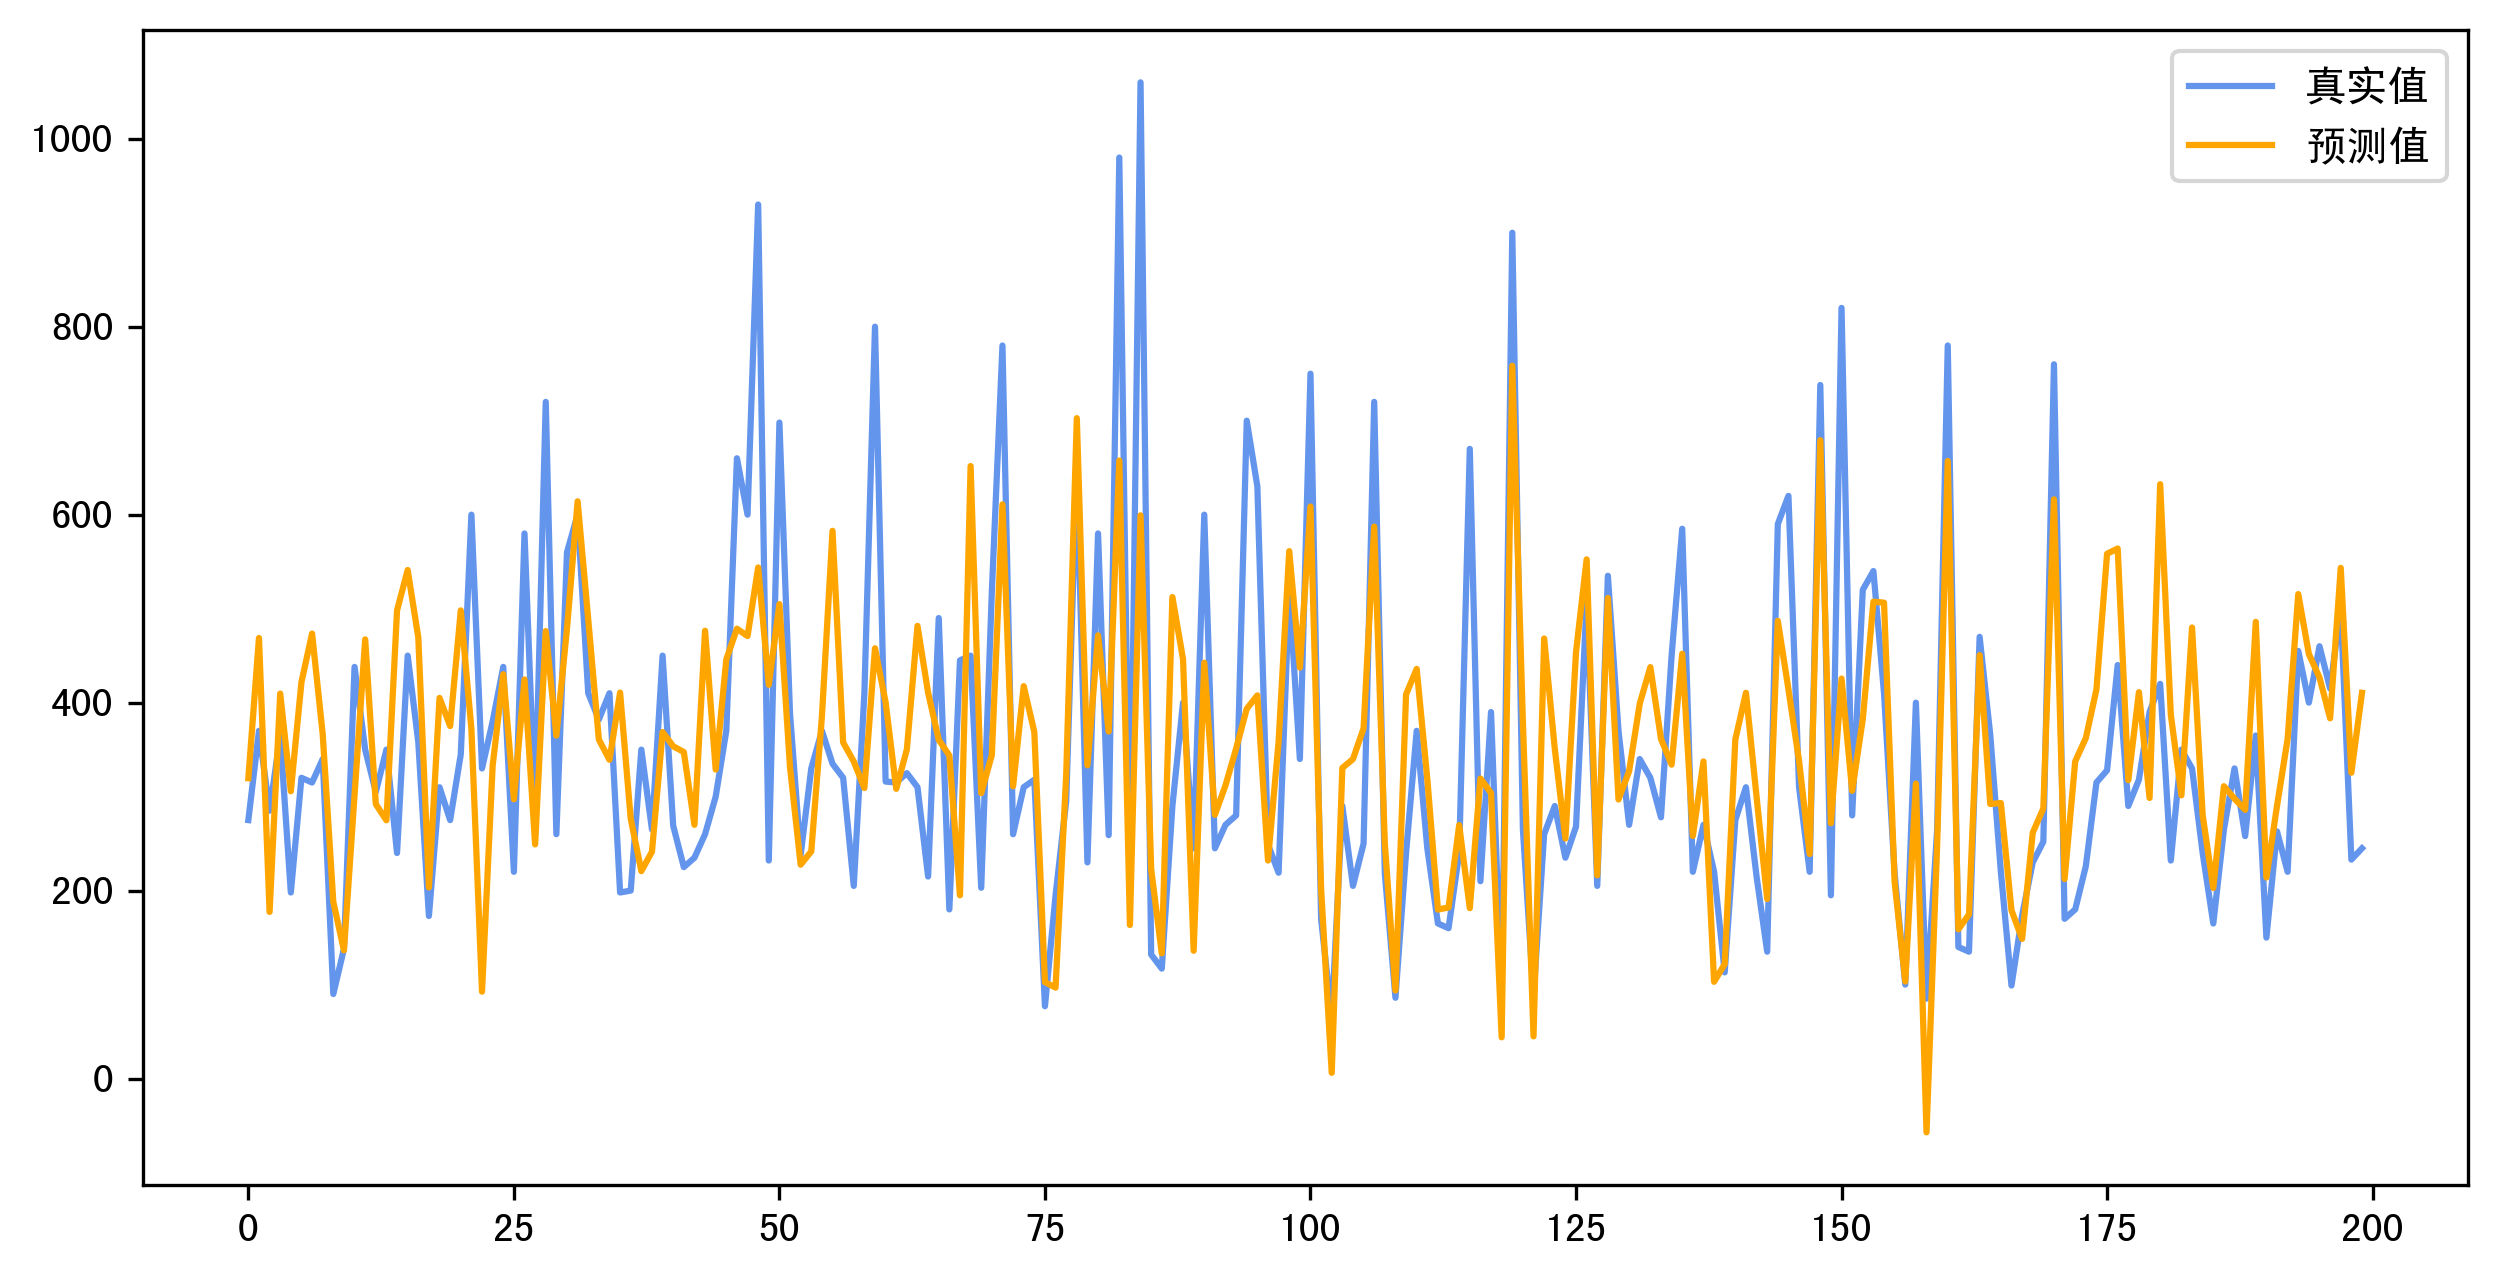

In [53]:
ypred=reg_lr.predict(xtest)
plot_compare(reg_lr,ytest,ypred)

In [54]:
#二、岭回归模型
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

# 创建 RidgeCV 模型实例，设定需要调优的 alpha 参数的取值范围
alphas = np.linspace(0, 300, 10)
reg_ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=42))
# 使用 RidgeCV 模型对数据进行拟合
reg_ridge.fit(xtrain,ytrain)
# 输出最优的 alpha 参数
print("Best alpha:", reg_ridge.alpha_)

Best alpha: 33.333333333333336


In [55]:
perfomance_reg(reg_ridge,xtrain,ytrain,'训练集')
perfomance_reg(reg_ridge,xtest,ytest,'测试集')

训练集 :
均方误差: 18572.56506093189
绝对平均误差: 99.6461545900327
R平方: 0.5378480121350704
平均绝对误差百分比: 0.3089318864128315
- - - - - - 
测试集 :
均方误差: 18443.597171406494
绝对平均误差: 98.448783346382
R平方: 0.5419793670343718
平均绝对误差百分比: 0.30170047004482087
- - - - - - 


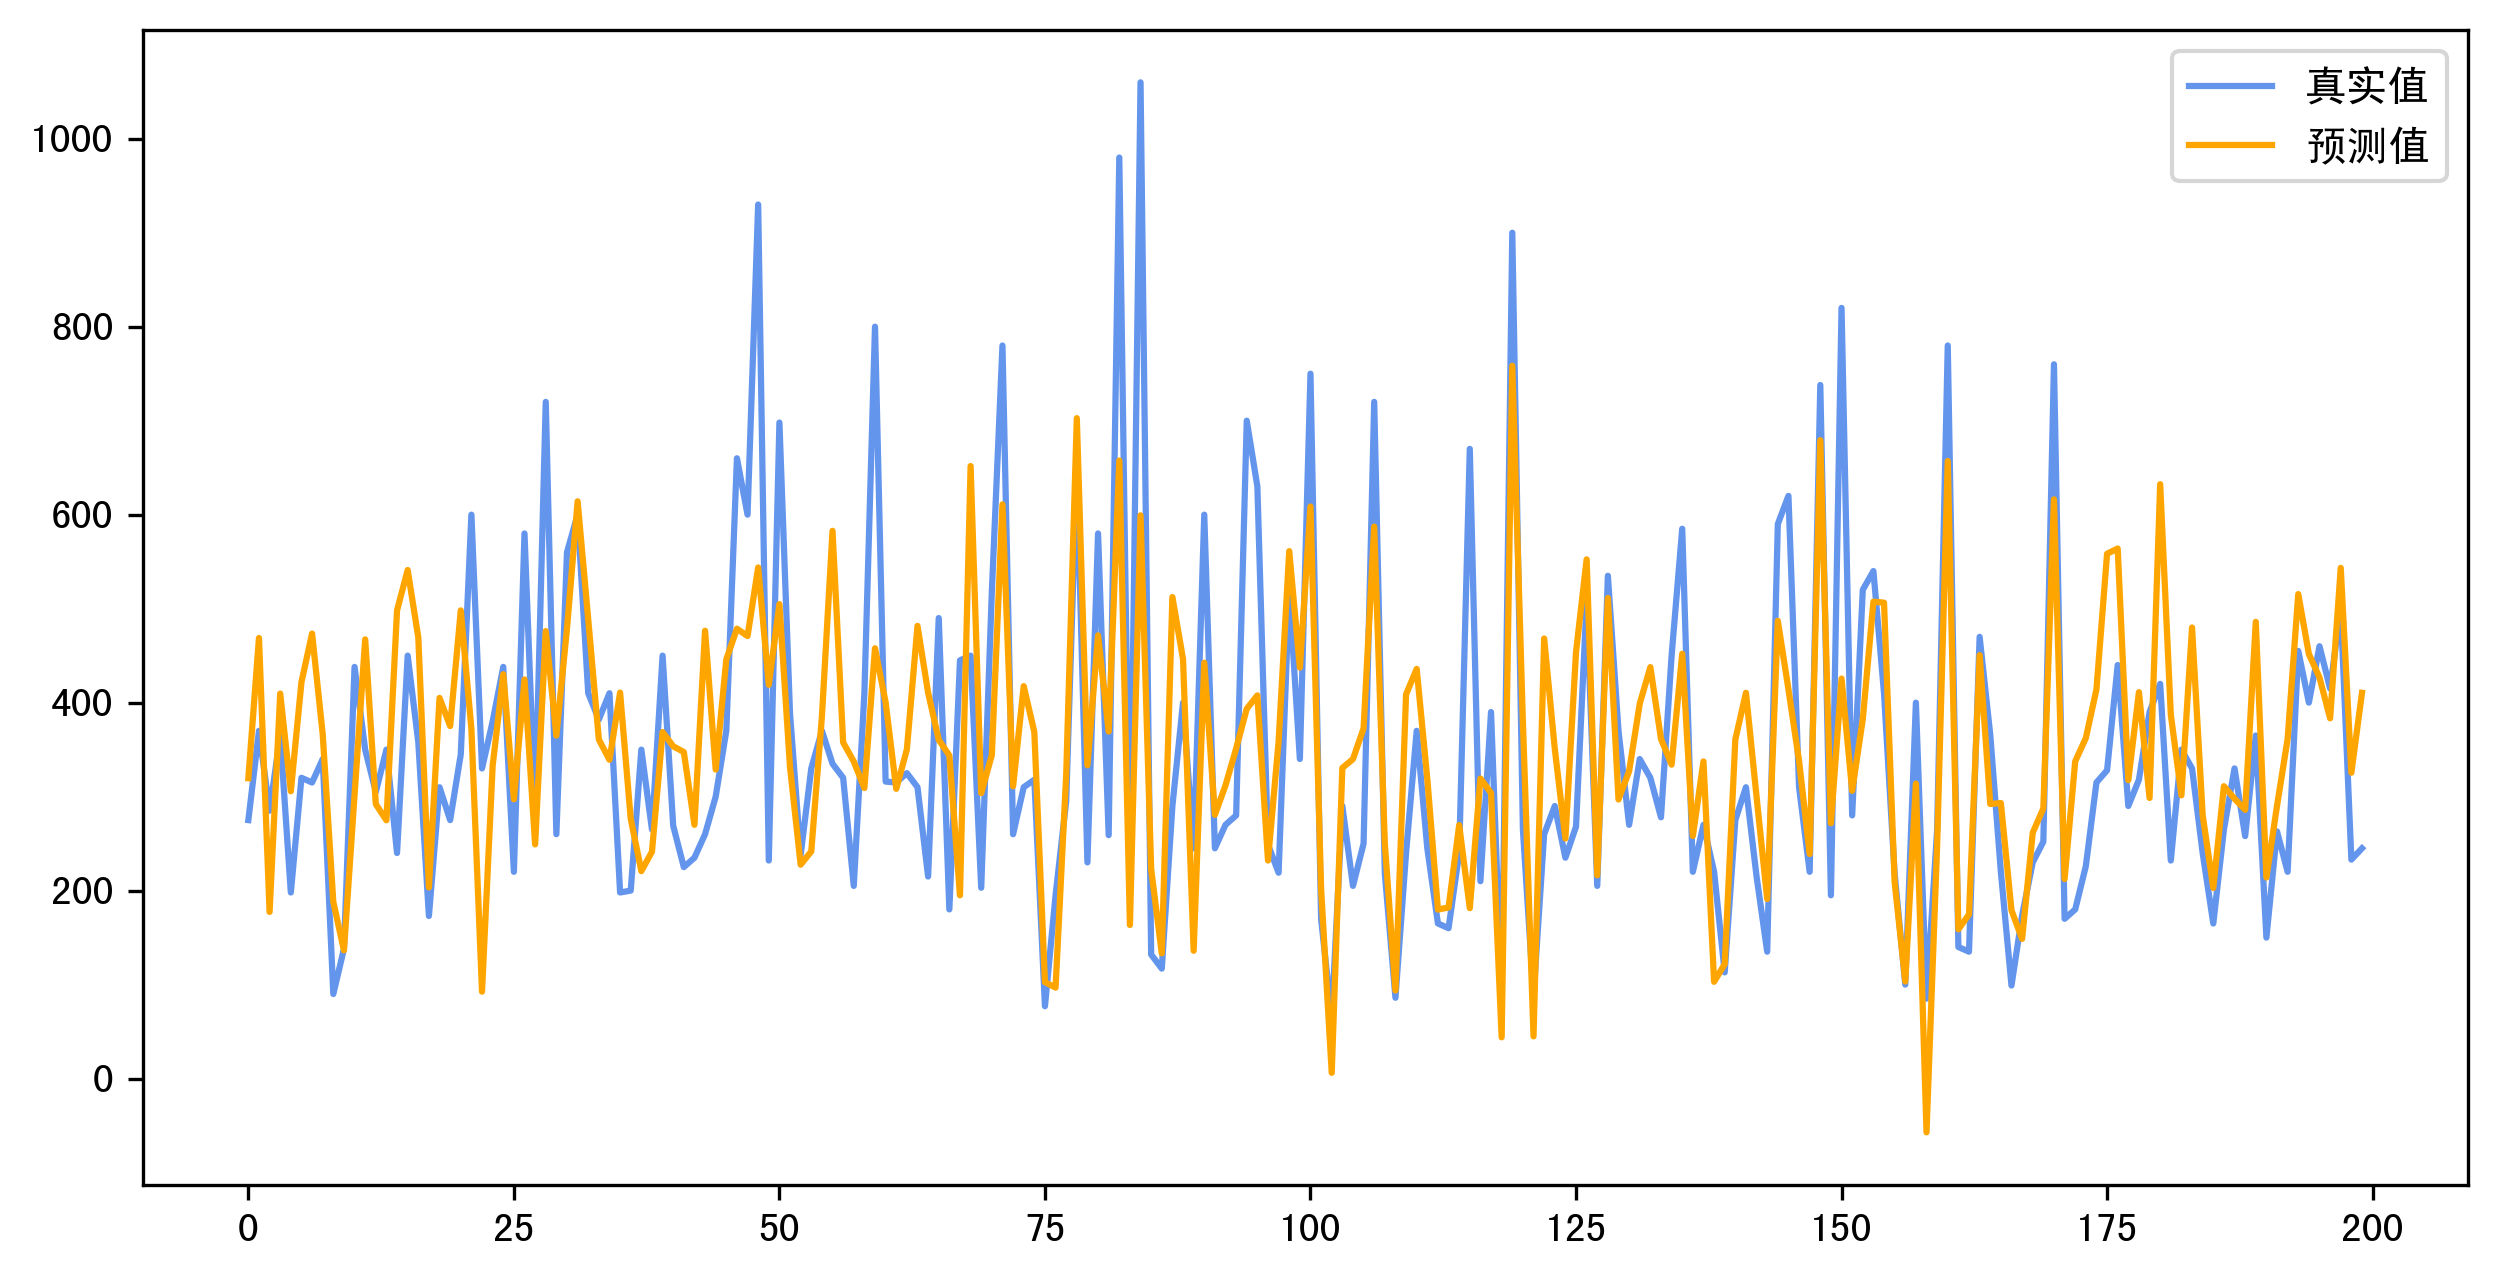

In [56]:
ypred = reg_ridge.predict(xtest)
plot_compare(reg_ridge,ytest,ypred)

支持向量机模型

In [60]:
reg_svc = SVC()
parameters = [
	{
		'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
	    'gamma': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
	    'kernel': ['rbf']
	},
	{
		'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
	    'kernel': ['linear']
	}
]

clf = GridSearchCV(reg_svc, parameters, cv=5, n_jobs=8)
clf.fit(xtrain, ytrain.astype('int64')) # 在用sklearn做分类任务的时候，y 应该是整数或者字符串型的向量

print(clf.best_params_)
reg_svc = clf.best_estimator_

perfomance_reg(reg_ridge,xtrain,ytrain,'训练集')
perfomance_reg(reg_ridge,xtest,ytest,'测试集')

KeyboardInterrupt: 

In [ ]:
ypred = reg_svc.predict(xtest)
plot_compare(reg_lr,ytest,ypred)

XGBoost模型

In [1]:
#XGBoost模型
import xgboost as xgb
from xgboost import XGBRegressor as XGBR   #sklearn的xgb接口
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
dtrain=xgb.DMatrix(xtrain,ytrain)
dtest=xgb.DMatrix(xtest,ytest)

In [ ]:
# #绘制num_round和r²的学习曲线
# axisx = range(100,4000,500)
# rs = []
# var = []
# ge = []

# param={
#         'objective':'reg:squarederror'
# #         ,'silent':False   #不打印每次训练结果   
#         ,'eta':0.1   
#        }

# for i in axisx:
#     xgbt=xgb.train(param,dtrain,i)
#     rs.append(r2_score(ytest,xgbt.predict(dtest)))
    
# plt.figure(figsize=(20,5))
# plt.plot(axisx,rs,c="red",label="XGB")
# plt.legend()
# plt.show()

In [ ]:
# #绘制eta和r²的学习曲线
# axisx = np.linspace(0,1,20)
# rs = []

# dtrain=xgb.DMatrix(xtrain,ytrain)
# dtest=xgb.DMatrix(xtest,ytest)

# for i in axisx:
#     param={
#             'objective':'reg:squarederror'
# #         ,'silent':False   #不打印每次训练结果   
#             ,'eta':i  
#            }
    
#     xgbt=xgb.train(param,dtrain,2000)
#     rs.append(r2_score(ytest,xgbt.predict(dtest)))
    
# print(axisx[rs.index(max(rs))],max(rs))
# plt.figure(figsize=(20,5))
# plt.plot(axisx,rs,c="green",label="XGB")
# plt.legend()
# plt.show()

In [ ]:
# #绘制subsample和r²学习曲线
# axisx = np.linspace(0,1,20)
# rs = []

# dtrain=xgb.DMatrix(xtrain,ytrain)
# dtest=xgb.DMatrix(xtest,ytest)

# for i in axisx:
#     param={
#             'objective':'reg:squarederror'
# #         ,'silent':False   #不打印每次训练结果   
#             ,'eta':0.1
#             ,'subsample':i
#            }
    
#     xgbt=xgb.train(param,dtrain,2000)
#     rs.append(r2_score(ytest,xgbt.predict(dtest)))
    
# print(axisx[rs.index(max(rs))],max(rs))
# plt.figure(figsize=(20,5))
# plt.plot(axisx,rs,c="green",label="XGB")
# plt.legend()
# plt.show()

In [ ]:
# #用xgb自带的网格搜索进行调参，绘制对比图

# from time import time
# import datetime

# param1 = {'silent':True
#           ,'obj':'reg:linear'
#           ,"subsample":1
#           ,"max_depth":6
#           ,"eta":0.3
#           ,"gamma":0
#           ,"lambda":1
#           ,"alpha":0
#           ,"colsample_bytree":1
#           ,"colsample_bylevel":1
#           ,"colsample_bynode":1
#           ,"nfold":5}
# num_round = 1500

# cvresult1 = xgb.cv(param1, dtrain, num_round)

# fig,ax = plt.subplots(1,figsize=(15,8))
# ax.set_ylim(top=120)
# ax.grid()
# ax.plot(range(1,1501),cvresult1.iloc[:,0],c="red",label="train,original")
# ax.plot(range(1,1501),cvresult1.iloc[:,2],c="orange",label="test,original")

# param2 ={'silent':True
#           ,'obj':'reg:squarederror'
#           ,"subsample":0.9
#           ,"max_depth":5
#           ,"eta":0.08
#           ,"gamma":0
#           ,"lambda":1
#           ,"alpha":0
#           ,"colsample_bytree":1
#           ,"colsample_bylevel":0.5
#           ,"colsample_bynode":0.8
#           ,"nfold":5}

# cvresult2 = xgb.cv(param2, dtrain, num_round)
# ax.plot(range(1,1501),cvresult2.iloc[:,0],c="green",label="train,last")
# ax.plot(range(1,1501),cvresult2.iloc[:,2],c="blue",label="test,last")
# ax.legend(fontsize="xx-large")
# plt.show()

In [ ]:
# dtrain=xgb.DMatrix(xtrain,ytrain)
# dtest=xgb.DMatrix(xtest,ytest)

# param = {'silent':True
#           ,'obj':'reg:squarederror'
#           ,"subsample":0.9
#           ,"max_depth":5
#           ,"eta":0.08
#           ,"gamma":0
#           ,"lambda":1
#           ,"alpha":0
#           ,"colsample_bytree":1
#           ,"colsample_bylevel":0.5
#           ,"colsample_bynode":0.8
#           ,"nfold":5}
# num_round = 1500

# xgbt = xgb.train(param, dtrain, num_round)
# preds = xgbt.predict(dtest)

# perfomance_reg(xgbt,dtrain,ytrain,'训练集')
# perfomance_reg(xgbt,dtest,ytest,'测试集')

In [11]:
reg_xgb = XGBR(
             objective='reg:squarederror'
            ,subsample=0.9
            ,max_depth=5
            ,n_estimators=1500
            ,learning_rate=0.08
            ,gamma=0
            ,reg_lambda=1
            ,reg_alpha=0
            ,colsample_bytree=1
            ,colsample_bylevel=0.5
            ,random_state=42
            ).fit(xtrain,ytrain)

perfomance_reg(reg_xgb,xtrain,ytrain,'训练集')
perfomance_reg(reg_xgb,xtest,ytest,'测试集')

训练集 :
均方误差: 975.725525105119
绝对平均误差: 21.65445283436148
R平方: 0.975720451668443
平均绝对误差百分比: 0.06887739028409846
- - - - - - 
测试集 :
均方误差: 3636.982700452143
绝对平均误差: 37.67087924081962
R平方: 0.9096806819697474
平均绝对误差百分比: 0.11078350259905513
- - - - - - 


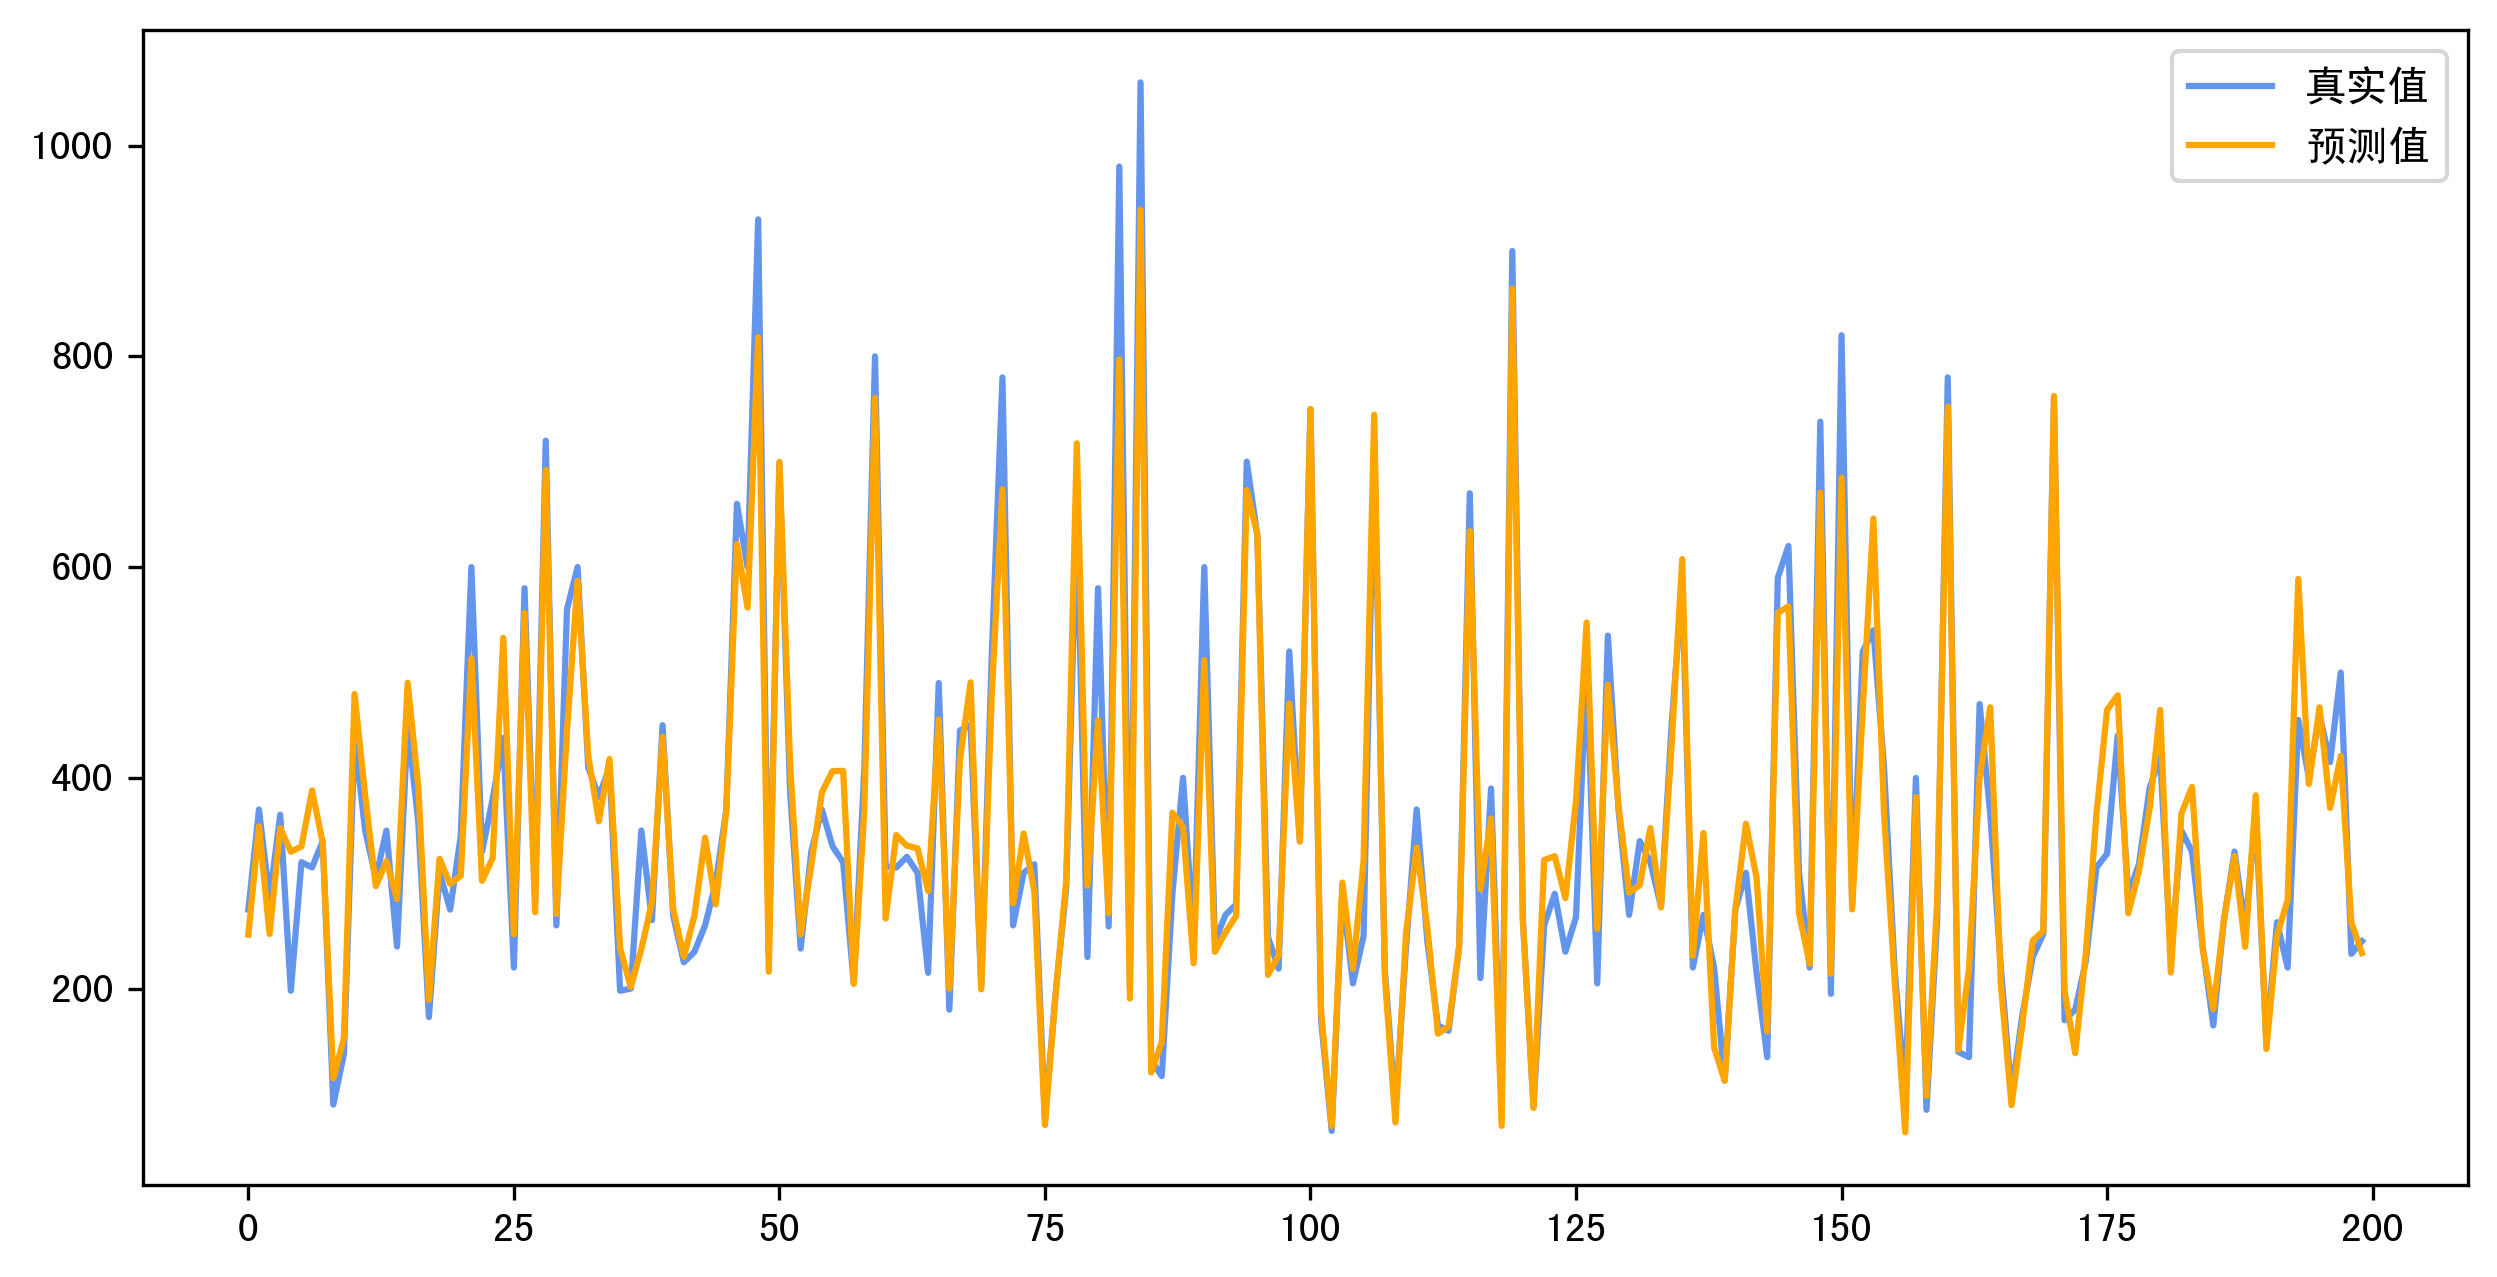

In [12]:
y_pred = reg_xgb.predict(xtest)
plot_compare(reg_xgb,ytest,y_pred)